# Clonal inference P3

In this notebook I run the clonal inference model on P3. This patient has the following alterations:

* DNMT3A
* TP53
* mt:2108G>A


There are 2 time point in the data:

* Diagnosis (Day 0)
* Post-treatment (Day 15)

## Import packages 

<br>


In [1]:
# Import packages
import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
import itertools
import os

import dill

import time
from datetime import datetime
from timeit import default_timer as timer
from datetime import timedelta

import scipy
from scipy.stats import betabinom

import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
from pyro.infer.autoguide import AutoDelta
from pyro.infer import SVI, Trace_ELBO, MCMC, NUTS, TraceEnum_ELBO, config_enumerate, infer_discrete
from pyro.optim import Adam, AdagradRMSProp, MultiStepLR
from torch.distributions import constraints
from pyro.ops.indexing import Vindex
pyro.set_rng_seed(100)

# import helper functions and tree class form source code files (present in the same directory)
from helper_functions import *

In [5]:
torch.set_default_tensor_type(torch.cuda.DoubleTensor)
patient = "P3"

# Create tree class object

This class contains all functions required to run the model and to generate diagnostic plots. 

In [23]:
input_file = "../data/input_" + patient + ".json"
t = create_tree_class(input_file, name = patient, mult_samp = True, cnv_celltype = False, gpu = True)

# Run model


In [24]:
# select initial 2 mutations based on the proportion of cells covered
t.sel_mutation(initial = True)

tensor([2, 0])

In [25]:
t.names

['DNMT3A', 'TP53', 'X2108.G.A']

In [26]:
t.af_beta

tensor([[55., 50.,  1.],
        [ 0.,  0.,  0.]])

In [27]:
t.muts

[2, 0]

## Initial tree with DNMT3A & X2108.G.A

In [28]:
# select the best tree(s)
t.select_tree(num_iter = 300, init = 100)

Choosing best tree among 4 potential candidates
Model fit to tree 0 in 1m 1s
Model fit to tree 1 in 1m 0s
Model fit to tree 2 in 1m 1s
Model fit to tree 3 in 0m 47s
Trees [0, 1, 3] selected for mutations ['X2108.G.A', 'DNMT3A']
tensor([[0., 0.],
        [1., 0.],
        [1., 1.]])
tensor([[0., 0.],
        [0., 1.],
        [1., 1.]])
tensor([[0., 0.],
        [1., 1.]])
Total run time 0h 3m 50s


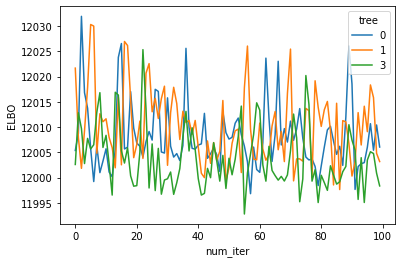

In [29]:
t.print_elbo(300, 200, include = [0,1,3])

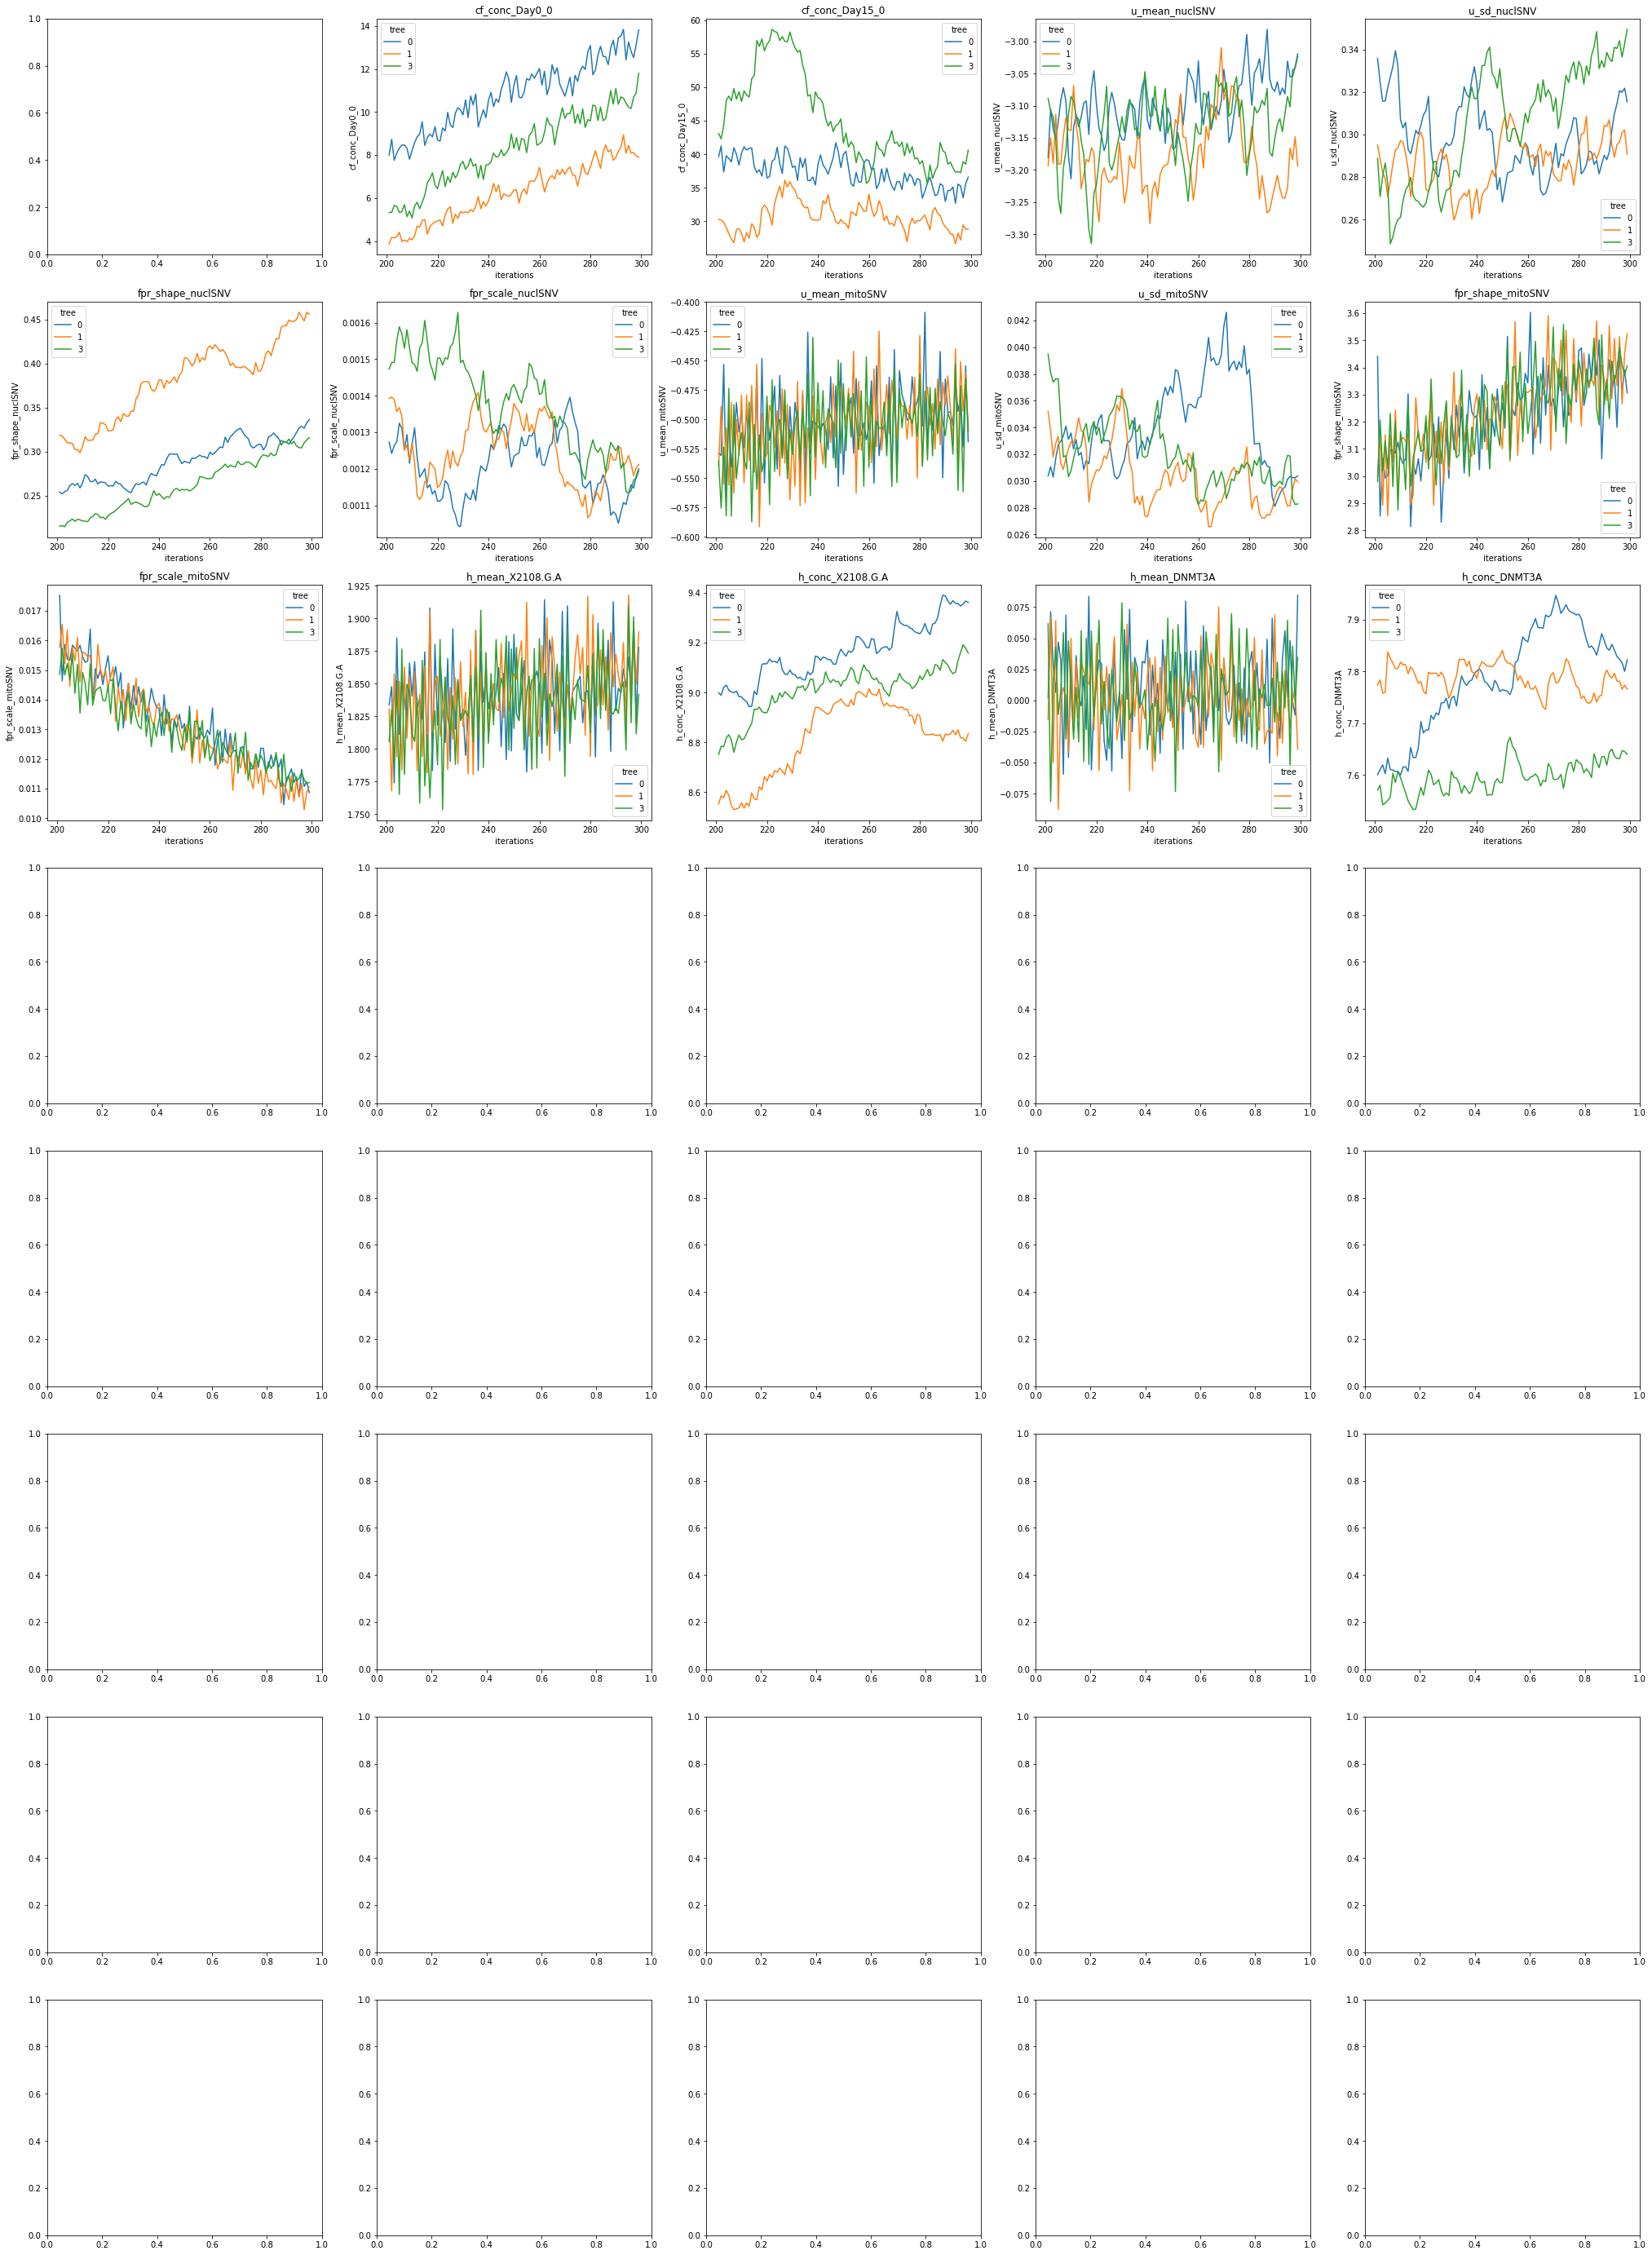

In [30]:
t.print_params(include = [0,1,3], it = 200)

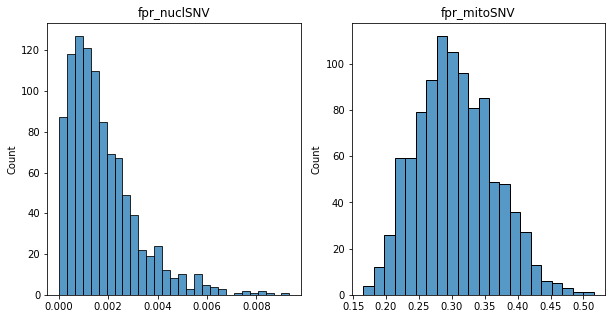

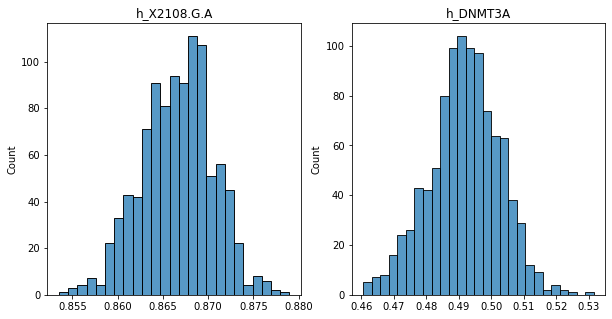

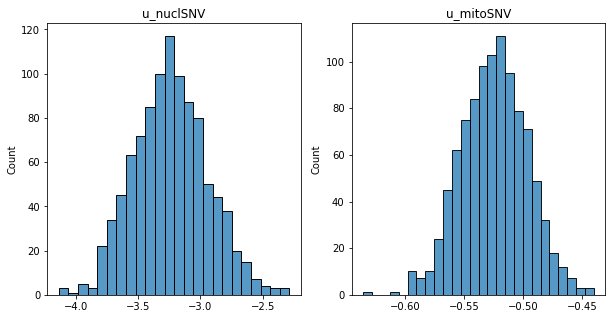

In [31]:
t.plot_posterior("all", 1, 1000)

## Add TP53

In [32]:
# add mutation and select the best tree(s)
t.add_mutation()
t.select_tree(num_iter = 300, init = 150)

TP53 added to the tree
Choosing best tree among 18 potential candidates
Model fit to tree 0 in 1m 12s
Model fit to tree 1 in 1m 18s
Model fit to tree 2 in 1m 18s
Model fit to tree 3 in 1m 11s
Model fit to tree 4 in 1m 18s
Model fit to tree 5 in 1m 10s
Model fit to tree 6 in 1m 7s
Model fit to tree 7 in 1m 10s
Model fit to tree 8 in 1m 11s
Model fit to tree 9 in 1m 9s
Model fit to tree 10 in 1m 17s
Model fit to tree 11 in 1m 19s
Model fit to tree 12 in 1m 16s
Model fit to tree 13 in 0m 57s
Model fit to tree 14 in 0m 53s
Model fit to tree 15 in 1m 1s
Model fit to tree 16 in 1m 2s
Model fit to tree 17 in 1m 13s
Trees [1, 2, 5, 8, 9, 15, 16, 17] selected for mutations ['X2108.G.A', 'DNMT3A', 'TP53']
tensor([[0., 0., 0.],
        [0., 0., 1.],
        [1., 0., 1.],
        [1., 1., 1.]])
tensor([[0., 0., 0.],
        [1., 0., 1.],
        [1., 1., 1.]])
tensor([[0., 0., 0.],
        [1., 0., 0.],
        [1., 1., 1.]])
tensor([[0., 0., 0.],
        [0., 0., 1.],
        [0., 1., 1.],
      

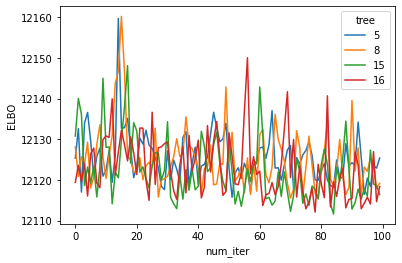

In [33]:
t.print_elbo(300, 200, include = [16,8,5, 15])

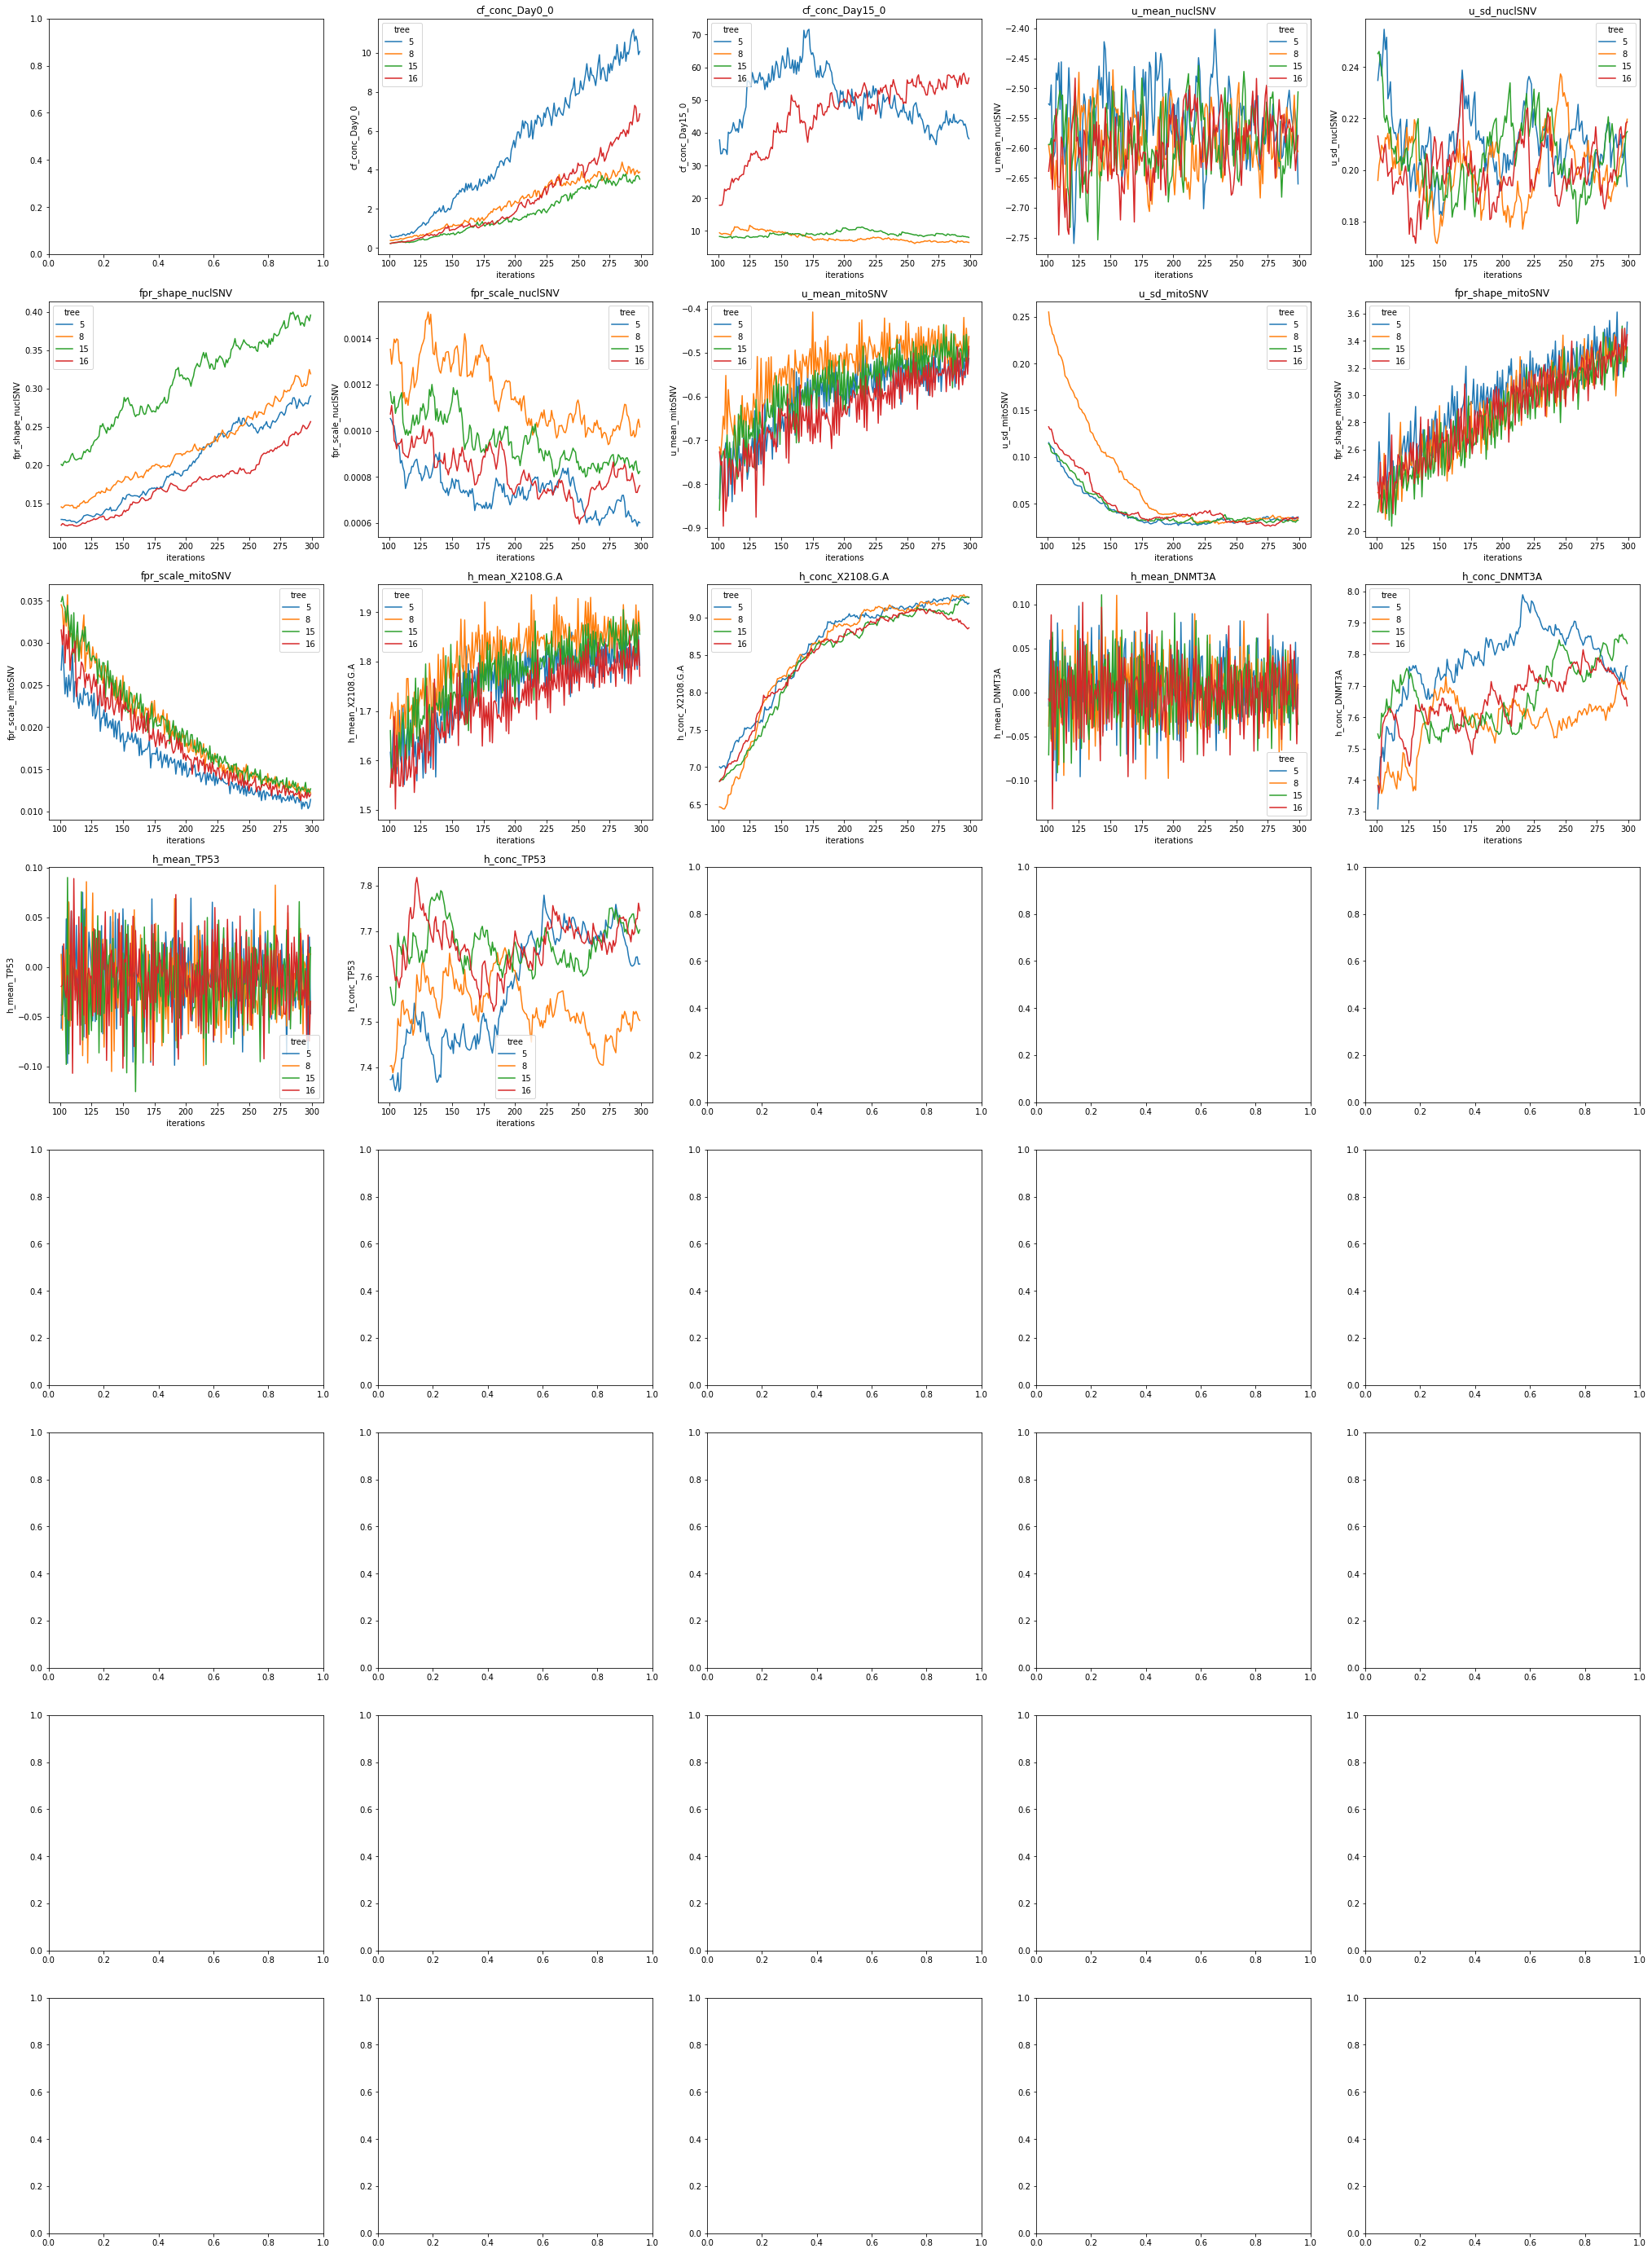

In [34]:
t.print_params(include = [16,8,5, 15], it = 100)

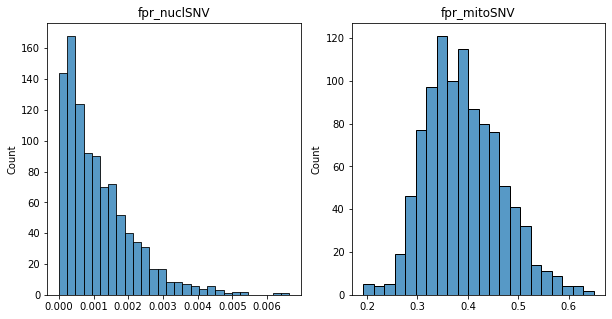

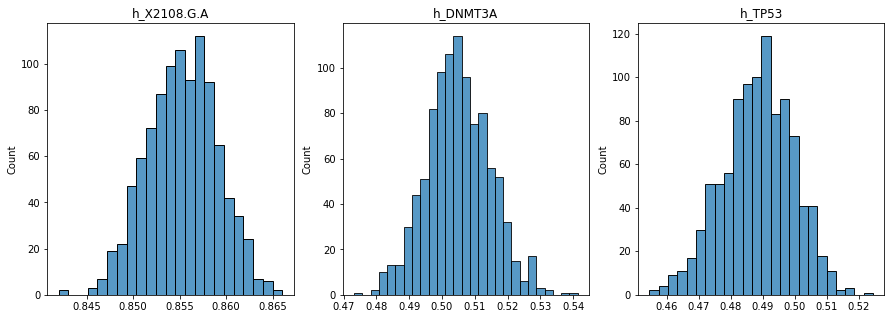

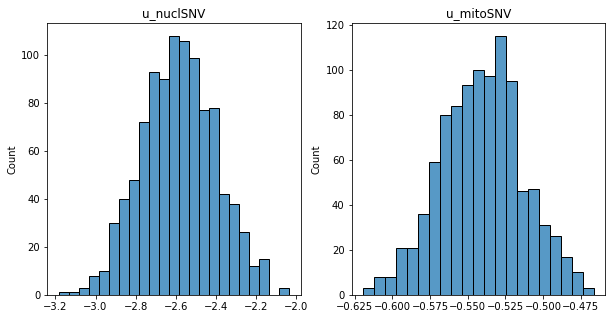

In [35]:
t.plot_posterior("all", 16, 1000)

# Infer clonal assignment probabilities

In [22]:
# Compute clonal assignment probabilities for all selected trees
for i in range(len(t.tree_indices)):
    t.clonal_assignment(tree = i)

Computing clonal assignment probabilities for tree 0
Clonal assignment probabilities computed in 1m and 16s
Computing clonal assignment probabilities for tree 1
Clonal assignment probabilities computed in 1m and 1s
Computing clonal assignment probabilities for tree 2
Clonal assignment probabilities computed in 1m and 18s
Computing clonal assignment probabilities for tree 3
Clonal assignment probabilities computed in 1m and 20s
Computing clonal assignment probabilities for tree 4
Clonal assignment probabilities computed in 1m and 6s
Computing clonal assignment probabilities for tree 5
Clonal assignment probabilities computed in 1m and 20s
Computing clonal assignment probabilities for tree 6
Clonal assignment probabilities computed in 1m and 19s
Computing clonal assignment probabilities for tree 7
Clonal assignment probabilities computed in 1m and 20s
Computing clonal assignment probabilities for tree 8
Clonal assignment probabilities computed in 1m and 21s


# Get posterior predictive 

In [26]:
# Get posterior predictive for tree with all mutations merge in one clone
t.get_post_predictive(tree = 16, num_samples = t.M.shape[0])

In [28]:
# export object as pickle
t.export_pickle("svi_objects/AKLA.pickle")

Tree object saved as pickle!
